# Notebook for CS506: Analysis of European League Soccer Players
By: Chanan Suksangium, Tachapan Kongboonma, Zhenjie Cao

This notebook explores clustering of European league soccer players based on their skill attributes with K-Means as we expect to see similar role players to be grouped together.

Dataset used is 'European Soccer Database' from Kaggle (https://www.kaggle.com/hugomathien/soccer)

In [1]:
#imported relevant modules and libraries
import numpy as np
from numpy import array
import pandas as pd
import sqlite3

from sklearn.feature_extraction import DictVectorizer
from sklearn import mixture
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import sklearn.metrics as metrics
import sklearn.manifold

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from pylab import plot, show

#Connect and query SQLite: format of file received from Kaggle
database = 'database.sqlite'
conn = sqlite3.connect(database)

query = "SELECT name FROM sqlite_master WHERE type='table';"
pd.read_sql(query, conn)

,name
0,sqlite_sequence
1,Player_Attributes
2,Player
3,Match
4,League
5,Country
6,Team
7,Team_Attributes


In [2]:
#select relevant data tables and columns from sqlite to be read as dataframe by pandas
query = """SELECT * FROM Player_Attributes a
           INNER JOIN (SELECT player_name, player_api_id AS p_id FROM Player) b ON a.player_api_id = b.p_id;"""

drop_cols = ['id','player_fifa_api_id','date','preferred_foot',
             'attacking_work_rate','defensive_work_rate']

players_ready = pd.read_sql(query, conn)
players_ready = players_ready.drop_duplicates(subset='player_api_id', keep='first')
players_ready = players_ready.drop(drop_cols, axis=1)
players_ready.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11060 entries, 0 to 183968
Data columns (total 38 columns):
player_api_id         11060 non-null int64
overall_rating        11060 non-null float64
potential             11060 non-null float64
crossing              11060 non-null float64
finishing             11060 non-null float64
heading_accuracy      11060 non-null float64
short_passing         11060 non-null float64
volleys               10582 non-null float64
dribbling             11060 non-null float64
curve                 10582 non-null float64
free_kick_accuracy    11060 non-null float64
long_passing          11060 non-null float64
ball_control          11060 non-null float64
acceleration          11060 non-null float64
sprint_speed          11060 non-null float64
agility               10582 non-null float64
reactions             11060 non-null float64
balance               10582 non-null float64
shot_power            11060 non-null float64
jumping               10582 non-null 

In [3]:
#check for null fields so they can be dropped/removed from analysis
players_ready.isnull().sum(axis=0)

player_api_id           0
overall_rating          0
potential               0
crossing                0
finishing               0
heading_accuracy        0
short_passing           0
volleys               478
dribbling               0
curve                 478
free_kick_accuracy      0
long_passing            0
ball_control            0
acceleration            0
sprint_speed            0
agility               478
reactions               0
balance               478
shot_power              0
jumping               478
stamina                 0
strength                0
long_shots              0
aggression              0
interceptions           0
positioning             0
vision                478
penalties               0
marking                 0
standing_tackle         0
sliding_tackle        478
gk_diving               0
gk_handling             0
gk_kicking              0
gk_positioning          0
gk_reflexes             0
player_name             0
p_id                    0
dtype: int64

In [4]:
rows = players_ready.shape[0]
# Drop the all null rows
players_ready = players_ready.dropna()
print(rows)
players_ready.isnull().any().any(), players_ready.shape

11060


(False, (10582, 38))

In [5]:
#check once again if null is cleared
players_ready.isnull().sum(axis=0)

player_api_id         0
overall_rating        0
potential             0
crossing              0
finishing             0
heading_accuracy      0
short_passing         0
volleys               0
dribbling             0
curve                 0
free_kick_accuracy    0
long_passing          0
ball_control          0
acceleration          0
sprint_speed          0
agility               0
reactions             0
balance               0
shot_power            0
jumping               0
stamina               0
strength              0
long_shots            0
aggression            0
interceptions         0
positioning           0
vision                0
penalties             0
marking               0
standing_tackle       0
sliding_tackle        0
gk_diving             0
gk_handling           0
gk_kicking            0
gk_positioning        0
gk_reflexes           0
player_name           0
p_id                  0
dtype: int64

## Analysis 1: Correlation Coefficients between 'overall_rating' and individual attributes
This step aims to give us a better understanding of overall rating by finding correlation coefficients with each individual attributes as listed in 'cols'. By seeing the correlation coefficients, we will be able to further understand the influence of each skill attributes.

In [6]:
#create a list of correlation coefficients to be plotted
cols = ['potential',  'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes']
correlations = [players_ready['overall_rating'].corr(players_ready[f]) for f in cols ]
print(len(cols)==len(correlations))

True


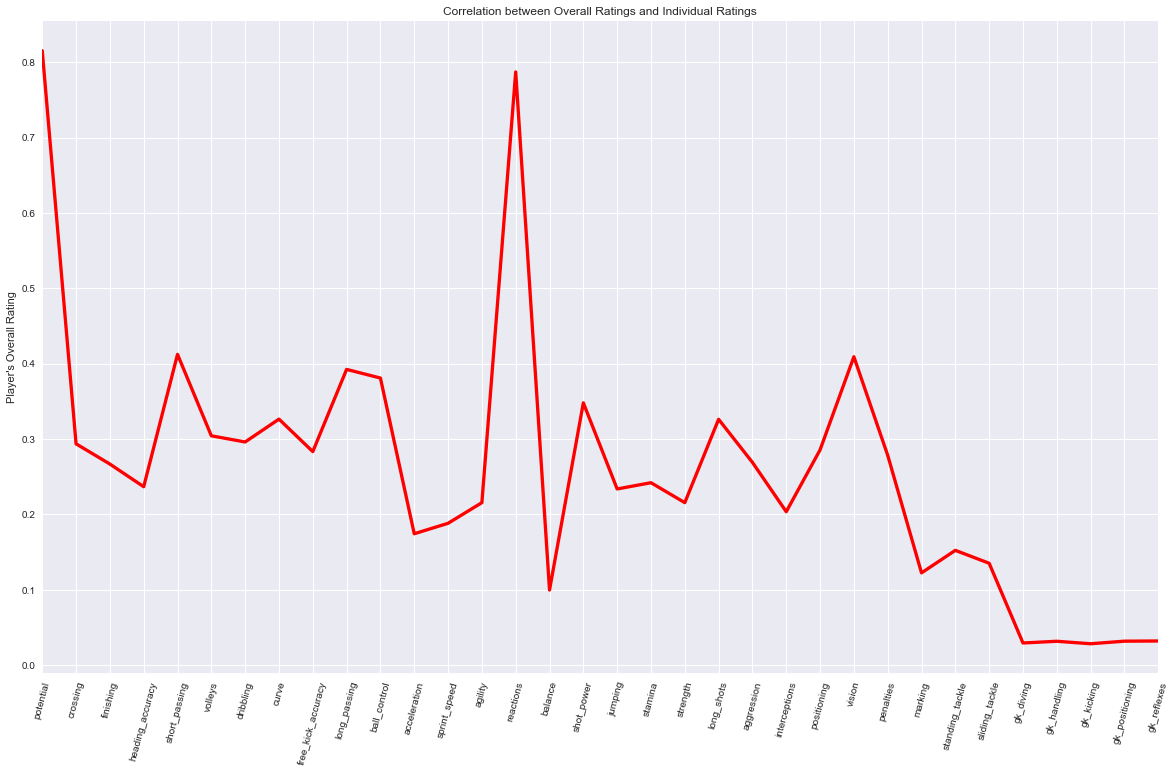

In [7]:
#Correlation coefficients are plotted on a line graph
def plot_dataframe(df, y_label):  
    color='red'
    fig = plt.gcf()
    fig.set_size_inches(20, 12)
    plt.ylabel(y_label)

    ax = df2.correlation.plot(linewidth=3.3, color=color)
    ax.set_xticks(df2.index)
    ax.set_xticklabels(df2.attributes, rotation=75); #Notice the ; (remove it and see what happens !)
    plt.title('Correlation between Overall Ratings and Individual Ratings')
    plt.show()

df2 = pd.DataFrame({'attributes': cols, 'correlation': correlations}) 
plot_dataframe(df2, 'Player\'s Overall Rating')

## Analysis 2: K-Means Clustering of Players by Skill Attributes

As we now see the correlation coefficients for each stats per graph above and further understand the data, we can begin the analysis 2: K-means Clustering. Here, we expect players of similar positions to be grouped together so K = 4 is used for 4 positions in soccer: Goalkeepers, Defenders, Midfielders, and Attackers.

In [8]:
#create new df of all stats
player_stats = pd.DataFrame(players_ready)
player_stats = player_stats.drop(['player_api_id','overall_rating','potential','player_name', 'p_id'], axis=1)
player_stats.head()


,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
5,80.0,53.0,58.0,71.0,40.0,73.0,70.0,69.0,68.0,71.0,...,66.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0
38,64.0,58.0,60.0,66.0,52.0,66.0,67.0,63.0,62.0,67.0,...,68.0,61.0,23.0,22.0,24.0,16.0,11.0,12.0,9.0,13.0
64,57.0,21.0,68.0,65.0,48.0,56.0,38.0,40.0,61.0,62.0,...,54.0,37.0,72.0,71.0,68.0,15.0,12.0,13.0,12.0,11.0
87,46.0,34.0,73.0,65.0,33.0,47.0,42.0,25.0,58.0,58.0,...,41.0,45.0,75.0,73.0,71.0,8.0,6.0,16.0,12.0,11.0


In [9]:
#K-means step

# Number of clusters
kstats = KMeans(n_clusters=4)
# Fitting the input data
kstats = kstats.fit(player_stats)
# Getting the cluster labels
kstats_label = kstats.predict(player_stats)
print(kstats_label)
df_stats = pd.DataFrame(kstats_label)
df_stats.head()

[3 2 0 ..., 2 3 0]


,0
0,3
1,2
2,0
3,3
4,3


In [10]:
#rename column name
df_stats.columns=['position']
df_stats.tail(10)
#df_stats.isnull().sum(axis=0)

,position
10572,3
10573,3
10574,0
10575,0
10576,3
10577,3
10578,3
10579,2
10580,3
10581,0


In [11]:
#remove null and reset index of main dataframe
players_ready.isnull().sum(axis=0)
players_ready = players_ready.reset_index()


In [12]:
players_ready.head()

,index,player_api_id,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,...,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_name,p_id
0,0,505942,67.0,71.0,49.0,44.0,71.0,61.0,44.0,51.0,...,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0,Aaron Appindangoye,505942
1,5,155782,74.0,76.0,80.0,53.0,58.0,71.0,40.0,73.0,...,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0,Aaron Cresswell,155782
2,38,162549,65.0,67.0,64.0,58.0,60.0,66.0,52.0,66.0,...,23.0,22.0,24.0,16.0,11.0,12.0,9.0,13.0,Aaron Doran,162549
3,64,30572,69.0,69.0,57.0,21.0,68.0,65.0,48.0,56.0,...,72.0,71.0,68.0,15.0,12.0,13.0,12.0,11.0,Aaron Galindo,30572
4,87,23780,70.0,70.0,46.0,34.0,73.0,65.0,33.0,47.0,...,75.0,73.0,71.0,8.0,6.0,16.0,12.0,11.0,Aaron Hughes,23780


In [13]:
players_ready=players_ready.drop("index",1)

In [14]:
#merge kmeans assignment back to original dataframe
players_ready['cluster'] = df_stats
players_ready.head()

,player_api_id,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,...,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_name,p_id,cluster
0,505942,67.0,71.0,49.0,44.0,71.0,61.0,44.0,51.0,45.0,...,69.0,69.0,6.0,11.0,10.0,8.0,8.0,Aaron Appindangoye,505942,3
1,155782,74.0,76.0,80.0,53.0,58.0,71.0,40.0,73.0,70.0,...,75.0,78.0,14.0,7.0,9.0,9.0,12.0,Aaron Cresswell,155782,2
2,162549,65.0,67.0,64.0,58.0,60.0,66.0,52.0,66.0,67.0,...,22.0,24.0,16.0,11.0,12.0,9.0,13.0,Aaron Doran,162549,0
3,30572,69.0,69.0,57.0,21.0,68.0,65.0,48.0,56.0,38.0,...,71.0,68.0,15.0,12.0,13.0,12.0,11.0,Aaron Galindo,30572,3
4,23780,70.0,70.0,46.0,34.0,73.0,65.0,33.0,47.0,42.0,...,73.0,71.0,8.0,6.0,16.0,12.0,11.0,Aaron Hughes,23780,3


In [15]:
#sort dataframe by cluster assignment
new_df = players_ready.sort_values(by=['cluster'])
#print(len(new_df'0')))
new_df.head()

,player_api_id,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,...,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_name,p_id,cluster
5290,5243,69.0,69.0,81.0,61.0,53.0,71.0,48.0,69.0,75.0,...,41.0,25.0,10.0,10.0,6.0,10.0,16.0,Julio Alvarez,5243,0
5266,75376,69.0,69.0,69.0,53.0,46.0,63.0,44.0,78.0,75.0,...,32.0,35.0,6.0,13.0,16.0,14.0,10.0,Julian Ramos Omar,75376,0
5263,213498,63.0,71.0,64.0,48.0,32.0,56.0,47.0,72.0,64.0,...,34.0,25.0,6.0,13.0,11.0,12.0,11.0,Julian Luque,213498,0
5259,33331,63.0,63.0,60.0,56.0,59.0,58.0,66.0,70.0,68.0,...,25.0,24.0,16.0,16.0,14.0,10.0,6.0,Julian Jenner,33331,0
5258,461356,67.0,74.0,65.0,66.0,46.0,65.0,68.0,72.0,52.0,...,25.0,24.0,14.0,9.0,8.0,10.0,12.0,Julian Green,461356,0


In [16]:
#check that data is properly sorted
new_df.tail(5)

,player_api_id,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,...,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_name,p_id,cluster
6636,170441,65.0,65.0,58.0,27.0,47.0,67.0,22.0,60.0,43.0,...,67.0,67.0,6.0,6.0,11.0,15.0,10.0,Marlon Pereira,170441,3
6637,305827,65.0,70.0,62.0,40.0,58.0,56.0,28.0,65.0,40.0,...,63.0,60.0,13.0,11.0,10.0,12.0,7.0,Marnick Vermijl,305827,3
6639,571379,64.0,74.0,67.0,37.0,53.0,59.0,34.0,59.0,42.0,...,66.0,62.0,9.0,6.0,14.0,16.0,7.0,Marnon-Thomas Busch,571379,3
6645,189957,63.0,65.0,30.0,45.0,59.0,50.0,35.0,56.0,69.0,...,65.0,62.0,7.0,5.0,6.0,13.0,13.0,Mart Dijkstra,189957,3
0,505942,67.0,71.0,49.0,44.0,71.0,61.0,44.0,51.0,45.0,...,69.0,69.0,6.0,11.0,10.0,8.0,8.0,Aaron Appindangoye,505942,3


In [17]:
#generate 4 dataframes based on respective clusters: 0, 1, 2, 3
pos_0 = new_df.cluster == 0.0
group_0 = new_df[pos_0]

pos_1 = new_df.cluster == 1.0
group_1 = new_df[pos_1]


pos_2 = new_df.cluster == 2.0
group_2 = new_df[pos_2]


pos_3 = new_df.cluster == 3.0
group_3 = new_df[pos_3]


In [18]:
#find mean of all attributes on 4 dataframes to be plotted on graph for data visualization
lst_0 = []
lst_1 = []
lst_2 = []
lst_3 = []
for elem in cols:
    lst_0.append(group_0[elem].mean())
    lst_1.append(group_1[elem].mean())
    lst_2.append(group_2[elem].mean())
    lst_3.append(group_3[elem].mean())


In [19]:
#prepping average dataframe to be plotted
average_0 = pd.DataFrame(lst_0)
average_0 = average_0.transpose()
average_0.columns=cols


average_1 = pd.DataFrame(lst_1)
average_1 = average_1.transpose()
average_1.columns=cols


average_2 = pd.DataFrame(lst_2)
average_2 = average_2.transpose()
average_2.columns=cols


average_3 = pd.DataFrame(lst_3)
average_3 = average_3.transpose()
average_3.columns=cols


In [20]:
#check that average values dataframe is correct
print(average_0.iloc[0])

potential             71.557559
crossing              59.019972
finishing             65.511234
heading_accuracy      58.555617
short_passing         64.642441
volleys               61.622469
dribbling             68.922053
curve                 60.704022
free_kick_accuracy    55.131761
long_passing          54.986963
ball_control          69.403051
acceleration          72.375312
sprint_speed          72.212483
agility               71.649653
reactions             65.675451
balance               68.378918
shot_power            69.084882
jumping               65.063245
stamina               64.480999
strength              64.501526
long_shots            62.746186
aggression            54.013592
interceptions         32.854924
positioning           67.176699
vision                62.171151
penalties             63.654646
marking               26.795284
standing_tackle       30.904577
sliding_tackle        27.904022
gk_diving             10.471012
gk_handling           10.531484
gk_kicki

Looking at the graph below, we are able to assign labels to clusters due to looking at average of each attributes

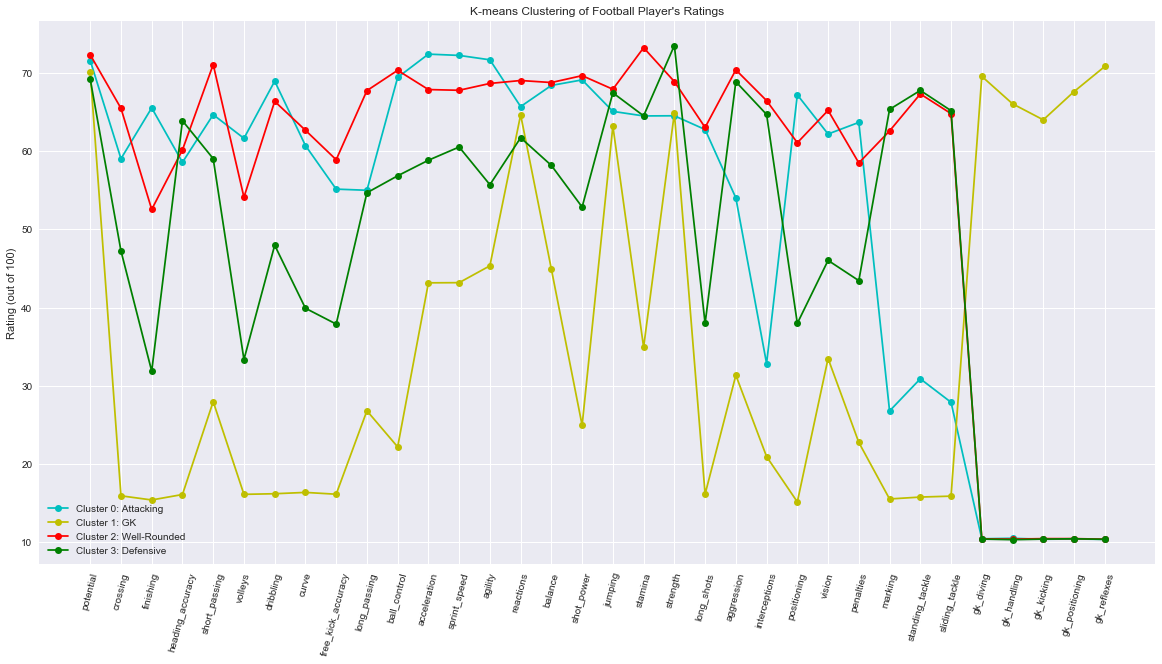

In [22]:
#plotting all average values of 4 clusters on single graph for visualization
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(111)

ax1.set_xticks(range(0,34))
ax1.set_xticklabels(cols, rotation=75); #Notice the ; (remove it and see what happens !)

ax1.plot(lst_0, color='c', label="Cluster 0: Attacking",marker='o')
ax1.plot(lst_1, color='y', label="Cluster 1: GK",marker='o')
ax1.plot(lst_2, color='r', label="Cluster 2: Well-Rounded",marker='o')
ax1.plot(lst_3, color='g', label="Cluster 3: Defensive",marker='o')
plt.legend(loc='best')
plt.title("K-means Clustering of Football Player's Ratings")
plt.ylabel('Rating (out of 100)')
plt.show()

In [23]:
#sort each cluster by overall rating to check accuracy of clusterings
#cluster 3
group_3 = group_3.sort_values(by=['overall_rating'],ascending=False)
group_3.head(15)

,player_api_id,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,...,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_name,p_id,cluster
3692,41884,86.0,86.0,52.0,33.0,84.0,49.0,45.0,52.0,56.0,...,90.0,90.0,3.0,3.0,2.0,4.0,3.0,Giorgio Chiellini,41884,3
7279,19327,85.0,85.0,48.0,43.0,83.0,64.0,51.0,62.0,32.0,...,90.0,89.0,12.0,6.0,10.0,13.0,12.0,Miranda,19327,3
654,30902,85.0,85.0,40.0,27.0,76.0,65.0,35.0,60.0,50.0,...,90.0,88.0,4.0,2.0,4.0,2.0,4.0,Andrea Barzagli,30902,3
5744,46539,84.0,84.0,54.0,32.0,84.0,75.0,35.0,62.0,22.0,...,87.0,85.0,13.0,11.0,9.0,11.0,7.0,Laurent Koscielny,46539,3
4886,30627,84.0,84.0,42.0,46.0,90.0,66.0,55.0,45.0,44.0,...,87.0,84.0,14.0,5.0,6.0,15.0,8.0,John Terry,30627,3
8163,25921,84.0,84.0,46.0,46.0,80.0,67.0,23.0,58.0,44.0,...,88.0,90.0,8.0,15.0,5.0,9.0,10.0,Pepe,25921,3
1650,165823,83.0,85.0,52.0,23.0,85.0,71.0,54.0,64.0,36.0,...,88.0,85.0,10.0,15.0,16.0,15.0,15.0,Chris Smalling,165823,3
6988,46875,83.0,83.0,45.0,49.0,85.0,66.0,31.0,57.0,34.0,...,87.0,86.0,7.0,4.0,8.0,7.0,11.0,Mehdi Benatia,46875,3
5623,161683,83.0,86.0,27.0,10.0,80.0,60.0,16.0,54.0,30.0,...,86.0,87.0,8.0,6.0,8.0,15.0,12.0,Konstantinos Manolas,161683,3
8167,35606,83.0,83.0,38.0,36.0,87.0,71.0,30.0,39.0,39.0,...,88.0,86.0,12.0,13.0,5.0,12.0,8.0,Per Mertesacker,35606,3


In [24]:
#sort each cluster by overall rating to check accuracy of clusterings
#cluster 2
group_2 = group_2.sort_values(by=['overall_rating'],ascending=False)
group_2.head(15)

,player_api_id,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,...,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_name,p_id,cluster
716,30955,88.0,88.0,79.0,73.0,54.0,92.0,74.0,90.0,80.0,...,57.0,56.0,6.0,13.0,6.0,13.0,7.0,Andres Iniesta,30955,2
9735,80562,88.0,88.0,60.0,38.0,82.0,79.0,63.0,68.0,61.0,...,91.0,89.0,9.0,12.0,5.0,9.0,10.0,Thiago Silva,80562,2
8220,30894,87.0,87.0,84.0,47.0,63.0,86.0,66.0,82.0,77.0,...,87.0,95.0,11.0,12.0,5.0,14.0,5.0,Philipp Lahm,30894,2
9992,95078,87.0,89.0,85.0,76.0,54.0,89.0,82.0,83.0,84.0,...,72.0,59.0,10.0,11.0,13.0,7.0,10.0,Toni Kroos,95078,2
6114,31097,87.0,87.0,78.0,71.0,55.0,86.0,75.0,86.0,79.0,...,75.0,73.0,13.0,9.0,7.0,14.0,9.0,Luka Modric,31097,2
3494,31921,87.0,89.0,84.0,81.0,76.0,84.0,76.0,87.0,87.0,...,65.0,62.0,15.0,15.0,11.0,5.0,6.0,Gareth Bale,31921,2
9266,30962,87.0,87.0,74.0,60.0,86.0,76.0,66.0,57.0,73.0,...,89.0,90.0,11.0,8.0,9.0,7.0,11.0,Sergio Ramos,30962,2
4662,36183,87.0,88.0,69.0,34.0,87.0,75.0,53.0,67.0,56.0,...,90.0,91.0,7.0,12.0,15.0,6.0,5.0,Jerome Boateng,36183,2
769,46509,86.0,86.0,90.0,75.0,53.0,81.0,77.0,87.0,83.0,...,63.0,61.0,10.0,7.0,11.0,12.0,11.0,Angel Di Maria,46509,2
9250,154257,86.0,87.0,62.0,60.0,70.0,89.0,44.0,74.0,66.0,...,86.0,80.0,5.0,8.0,13.0,9.0,13.0,Sergio Busquets,154257,2


In [25]:
#sort each cluster by overall rating to check accuracy of clusterings
#cluster 1
group_1 = group_1.sort_values(by=['overall_rating'],ascending=False)
group_1.head(15)

,player_api_id,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,...,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_name,p_id,cluster
6276,27299,90.0,90.0,15.0,13.0,25.0,48.0,11.0,16.0,14.0,...,10.0,11.0,85.0,87.0,91.0,90.0,87.0,Manuel Neuer,27299,1
2236,182917,87.0,90.0,17.0,13.0,21.0,31.0,13.0,13.0,21.0,...,21.0,13.0,88.0,81.0,86.0,85.0,89.0,David De Gea,182917,1
8200,30859,86.0,86.0,19.0,12.0,19.0,35.0,17.0,12.0,13.0,...,13.0,12.0,83.0,84.0,77.0,85.0,85.0,Petr Cech,30859,1
9743,170323,86.0,90.0,14.0,14.0,13.0,32.0,12.0,13.0,19.0,...,18.0,16.0,84.0,87.0,69.0,86.0,88.0,Thibaut Courtois,170323,1
4073,26295,85.0,85.0,13.0,10.0,10.0,27.0,11.0,10.0,11.0,...,10.0,18.0,87.0,82.0,68.0,81.0,88.0,Hugo Lloris,26295,1
3653,30717,84.0,84.0,13.0,15.0,13.0,37.0,17.0,25.0,20.0,...,11.0,11.0,85.0,79.0,71.0,89.0,83.0,Gianluigi Buffon,30717,1
9009,42422,84.0,84.0,12.0,10.0,10.0,33.0,12.0,18.0,12.0,...,10.0,13.0,87.0,80.0,70.0,87.0,87.0,Samir Handanovic,42422,1
4805,31432,84.0,84.0,14.0,14.0,10.0,32.0,19.0,23.0,17.0,...,14.0,13.0,84.0,81.0,75.0,84.0,88.0,Joe Hart,31432,1
9563,31293,83.0,83.0,14.0,13.0,13.0,31.0,13.0,11.0,13.0,...,12.0,13.0,85.0,78.0,79.0,81.0,84.0,Steve Mandanda,31293,1
9526,41097,83.0,83.0,11.0,11.0,12.0,33.0,13.0,12.0,17.0,...,12.0,11.0,83.0,81.0,77.0,83.0,86.0,Stephane Ruffier,41097,1


In [26]:
#sort each cluster by overall rating to check accuracy of clusterings
#cluster 0
group_0 = group_0.sort_values(by=['overall_rating'],ascending=False)
group_0.head(15)

,player_api_id,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,...,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_name,p_id,cluster
5909,30981,94.0,94.0,80.0,93.0,71.0,88.0,85.0,96.0,89.0,...,23.0,21.0,6.0,11.0,15.0,14.0,8.0,Lionel Messi,30981,0
1908,30893,93.0,93.0,82.0,95.0,86.0,81.0,87.0,93.0,88.0,...,31.0,23.0,7.0,11.0,15.0,14.0,11.0,Cristiano Ronaldo,30893,0
7528,19533,90.0,94.0,72.0,88.0,62.0,78.0,83.0,94.0,78.0,...,24.0,33.0,9.0,9.0,15.0,15.0,11.0,Neymar,19533,0
6102,40636,90.0,90.0,77.0,90.0,77.0,82.0,87.0,88.0,86.0,...,45.0,38.0,27.0,25.0,31.0,33.0,37.0,Luis Suarez,40636,0
10563,35724,89.0,89.0,76.0,90.0,76.0,84.0,92.0,87.0,80.0,...,41.0,27.0,13.0,15.0,10.0,9.0,12.0,Zlatan Ibrahimovic,35724,0
916,30834,89.0,89.0,80.0,85.0,51.0,85.0,86.0,93.0,86.0,...,26.0,26.0,10.0,8.0,11.0,5.0,15.0,Arjen Robben,30834,0
9242,37412,88.0,88.0,70.0,90.0,68.0,79.0,85.0,89.0,82.0,...,20.0,12.0,13.0,15.0,6.0,11.0,14.0,Sergio Aguero,37412,0
8645,93447,88.0,89.0,62.0,89.0,83.0,82.0,84.0,85.0,77.0,...,42.0,19.0,15.0,6.0,12.0,8.0,10.0,Robert Lewandowski,93447,0
2706,107417,88.0,90.0,80.0,81.0,57.0,85.0,79.0,94.0,82.0,...,27.0,22.0,11.0,12.0,6.0,8.0,8.0,Eden Hazard,107417,0
7014,36378,88.0,89.0,80.0,75.0,54.0,89.0,77.0,86.0,84.0,...,16.0,19.0,6.0,14.0,10.0,6.0,14.0,Mesut Oezil,36378,0


After each clusters have been sorted by overall rating, we want to check top 5 of group to test accuracy of k-means

In [27]:
offensive = group_0[['player_name', 'overall_rating','crossing','finishing', 'standing_tackle','sliding_tackle'
              ,'gk_diving', 'gk_positioning']]
offensive.head()

,player_name,overall_rating,crossing,finishing,standing_tackle,sliding_tackle,gk_diving,gk_positioning
5909,Lionel Messi,94.0,80.0,93.0,23.0,21.0,6.0,14.0
1908,Cristiano Ronaldo,93.0,82.0,95.0,31.0,23.0,7.0,14.0
7528,Neymar,90.0,72.0,88.0,24.0,33.0,9.0,15.0
6102,Luis Suarez,90.0,77.0,90.0,45.0,38.0,27.0,33.0
10563,Zlatan Ibrahimovic,89.0,76.0,90.0,41.0,27.0,13.0,9.0


In [28]:
gk = group_1[['player_name', 'overall_rating','crossing','finishing', 'standing_tackle','sliding_tackle'
              ,'gk_diving', 'gk_positioning']]
gk.head()

,player_name,overall_rating,crossing,finishing,standing_tackle,sliding_tackle,gk_diving,gk_positioning
6276,Manuel Neuer,90.0,15.0,13.0,10.0,11.0,85.0,90.0
2236,David De Gea,87.0,17.0,13.0,21.0,13.0,88.0,85.0
8200,Petr Cech,86.0,19.0,12.0,13.0,12.0,83.0,85.0
9743,Thibaut Courtois,86.0,14.0,14.0,18.0,16.0,84.0,86.0
4073,Hugo Lloris,85.0,13.0,10.0,10.0,18.0,87.0,81.0


In [29]:
well_rounded = group_2[['player_name', 'overall_rating','crossing','finishing', 'standing_tackle','sliding_tackle'
              ,'gk_diving', 'gk_positioning']]
well_rounded.head()

,player_name,overall_rating,crossing,finishing,standing_tackle,sliding_tackle,gk_diving,gk_positioning
716,Andres Iniesta,88.0,79.0,73.0,57.0,56.0,6.0,13.0
9735,Thiago Silva,88.0,60.0,38.0,91.0,89.0,9.0,9.0
8220,Philipp Lahm,87.0,84.0,47.0,87.0,95.0,11.0,14.0
9992,Toni Kroos,87.0,85.0,76.0,72.0,59.0,10.0,7.0
6114,Luka Modric,87.0,78.0,71.0,75.0,73.0,13.0,14.0


In [30]:
defensive = group_3[['player_name', 'overall_rating','crossing','finishing', 'standing_tackle','sliding_tackle'
              ,'gk_diving', 'gk_positioning']]
defensive.head()

,player_name,overall_rating,crossing,finishing,standing_tackle,sliding_tackle,gk_diving,gk_positioning
3692,Giorgio Chiellini,86.0,52.0,33.0,90.0,90.0,3.0,4.0
7279,Miranda,85.0,48.0,43.0,90.0,89.0,12.0,13.0
654,Andrea Barzagli,85.0,40.0,27.0,90.0,88.0,4.0,2.0
5744,Laurent Koscielny,84.0,54.0,32.0,87.0,85.0,13.0,11.0
4886,John Terry,84.0,42.0,46.0,87.0,84.0,14.0,15.0


## Results:

From interpretting our labelling of clusters based on averge line graph, we can see that performing k-means on 34 skill attributes provided quite an accurate clustering because the top players of each clusters correspond to their playstyles in real life, except perhaps, Thiago Silva in well_rounded group because he would be more suitable as a defensive player based on his role at Paris Saint Germain. Aside from that, k-means did a good job.